# Setup and Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Loading the Dataset
Loading the fixed games dataset. The original CSV had a header error where a comma was missing between Discount and DLC count, which was manually corrected and saved as games_fixed.csv.

In [2]:
df = pd.read_csv('data/raw/games_fixed.csv')

print(f"Dataset shape: {df.shape}")
print(f"Total records: {df.shape[0]}")
print(f"Total features: {df.shape[1]}")
df.head()

Dataset shape: (111452, 40)
Total records: 111452
Total features: 40


,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,Discount,DLC count,About the game,Supported languages,Full audio languages,Reviews,Header image,Website,Support url,Support email,Windows,Mac,Linux,Metacritic score,Metacritic url,User score,Positive,Negative,Score rank,Achievements,Recommendations,Notes,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,0,Galactic Bowling is an exaggerated and stylize...,['English'],[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://www.galacticbowling.net,NaN,NaN,True,False,False,0,NaN,0,6,11,NaN,30,0,NaN,0,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://trainbandit.com,NaN,support@rustymoyher.com,True,True,False,0,NaN,0,53,5,NaN,12,0,NaN,0,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,NaN,ramoncampiaof31@gmail.com,True,False,False,0,NaN,0,0,0,NaN,0,0,NaN,0,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,https://henosisgame.com/,https://henosisgame.com/,info@henosisgame.com,True,True,True,0,NaN,0,3,0,NaN,0,0,NaN,0,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,https://www.unusual-games.com/home/,https://www.unusual-games.com/contact/,welistentoyou@unusual-games.com,True,True,False,0,NaN,0,50,8,NaN,17,0,This Game may contain content not appropriate ...,0,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


# Initial Data Exploration
Check basic information about the dataset including data types and missing values.

In [3]:
print("Dataset Info:")
print(df.info())
print("\n" + "="*50 + "\n")
print("Missing Values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Percentage': missing_pct})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111452 entries, 0 to 111451
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AppID                       111452 non-null  int64  
 1   Name                        111446 non-null  object 
 2   Release date                111452 non-null  object 
 3   Estimated owners            111452 non-null  object 
 4   Peak CCU                    111452 non-null  int64  
 5   Required age                111452 non-null  int64  
 6   Price                       111452 non-null  float64
 7   Discount                    111452 non-null  int64  
 8   DLC count                   111452 non-null  int64  
 9   About the game              104969 non-null  object 
 10  Supported languages         111452 non-null  object 
 11  Full audio languages        111452 non-null  object 
 12  Reviews                     10624 non-null   object 
 13  

# Removing Irrelevant or "Cheat" Features
Removing features that are:
- Blatantly irrelevant (e.g., URLs, images, identifiers)
- Would allow the model to "cheat" (e.g., Peak CCU, reviews, playtime stats measured after launch)

Our goal is to predict game popularity **before or at launch**, so post-launch metrics must be removed.

In [4]:
print("Original columns:")
print(df.columns.tolist())

# Features to drop
dropped_cols = [
    'AppID', 'Name', 'Required age', 'Discount', 'Peak CCU', 'Positive', 'Negative', 'Recommendations',
    'Score rank', 'User score', 'Metacritic score', 'Metacritic url',
    'Header image', 'Website', 'Support url', 'Support email',
    'Reviews', 'Notes', 'Screenshots', 'Movies',
    'Average playtime forever', 'Median playtime forever',
    'Average playtime two weeks', 'Median playtime two weeks'
]

df = df.drop(columns=dropped_cols)

print(f"\nDropped {len(dropped_cols)} features")
print(f"Remaining features: {df.shape[1]}")
print("\nRemaining columns:")
print(df.columns.tolist())

Original columns:
['AppID', 'Name', 'Release date', 'Estimated owners', 'Peak CCU', 'Required age', 'Price', 'Discount', 'DLC count', 'About the game', 'Supported languages', 'Full audio languages', 'Reviews', 'Header image', 'Website', 'Support url', 'Support email', 'Windows', 'Mac', 'Linux', 'Metacritic score', 'Metacritic url', 'User score', 'Positive', 'Negative', 'Score rank', 'Achievements', 'Recommendations', 'Notes', 'Average playtime forever', 'Average playtime two weeks', 'Median playtime forever', 'Median playtime two weeks', 'Developers', 'Publishers', 'Categories', 'Genres', 'Tags', 'Screenshots', 'Movies']

Dropped 24 features
Remaining features: 16

Remaining columns:
['Release date', 'Estimated owners', 'Price', 'DLC count', 'About the game', 'Supported languages', 'Full audio languages', 'Windows', 'Mac', 'Linux', 'Achievements', 'Developers', 'Publishers', 'Categories', 'Genres', 'Tags']


# Feature Engineering - Release Date
Parse the Release date field and extract year, month, and day as separate numeric features.

In [5]:
if 'Release date' in df.columns:
    print("Processing Release date field...")
    
    # Convert to datetime
    df['Release date'] = pd.to_datetime(df['Release date'], errors='coerce')
    
    # Extract year, month, and day as separate features
    df['Release_Year'] = df['Release date'].dt.year
    df['Release_Month'] = df['Release date'].dt.month
    df['Release_Day'] = df['Release date'].dt.day
    
    # Drop the original Release date column
    df = df.drop(columns=['Release date'])
    
    print("Created new features: Release_Year, Release_Month, Release_Day")
    print(f"Sample: Year={df['Release_Year'].iloc[0]}, Month={df['Release_Month'].iloc[0]}, Day={df['Release_Day'].iloc[0]}")
else:
    print("Release date column not found")

Processing Release date field...
Created new features: Release_Year, Release_Month, Release_Day
Sample: Year=2008.0, Month=10.0, Day=21.0


# Target Variable Analysis and Transformation
Analyzing 'Estimated owners' and creating a categorical target variable 'popularity_class' with three levels:
- **Low**: ≤ 50,000 owners
- **Medium**: 50,001 - 500,000 owners
- **High**: > 500,000 owners

In [6]:
print("Unique values in 'Estimated owners':")
print(df['Estimated owners'].value_counts().sort_index())

# Check for and remove '0 - 0' range (noisy data)
print(f"\nRows with '0 - 0' range: {(df['Estimated owners'] == '0 - 0').sum()}")
df = df[df['Estimated owners'] != '0 - 0'].copy()
print(f"Rows after removal: {len(df)}")

Unique values in 'Estimated owners':
Estimated owners
0 - 0                    22091
0 - 20000                70206
100000 - 200000           2664
1000000 - 2000000          525
10000000 - 20000000         38
100000000 - 200000000        1
20000 - 50000             8277
200000 - 500000           2206
2000000 - 5000000          336
20000000 - 50000000         21
50000 - 100000            4068
500000 - 1000000           921
5000000 - 10000000          93
50000000 - 100000000         5
Name: count, dtype: int64

Rows with '0 - 0' range: 22091
Rows after removal: 89361


In [7]:
def categorize_popularity(owners_range):
    """
    Categorize game popularity based on estimated owners range.
    Low: <= 50,000
    Medium: 50,001 - 500,000
    High: > 500,000
    """
    if pd.isna(owners_range):
        return None
    
    # Remove commas and parse the range
    owners_range = owners_range.replace(',', '')
    low, high = map(int, owners_range.split(' - '))
    
    if high <= 50000:
        return 'Low'
    elif high <= 500000:
        return 'Medium'
    else:
        return 'High'

# Apply categorization
df['popularity_class'] = df['Estimated owners'].apply(categorize_popularity)

# Check distribution
print("Popularity class distribution:")
print(df['popularity_class'].value_counts())
print("\nPercentage distribution:")
print(df['popularity_class'].value_counts(normalize=True) * 100)

Popularity class distribution:
popularity_class
Low       78483
Medium     8938
High       1940
Name: count, dtype: int64

Percentage distribution:
popularity_class
Low       87.826904
Medium    10.002126
High       2.170969
Name: proportion, dtype: float64


In [8]:
# Remove the original 'Estimated owners' column
df = df.drop(columns=['Estimated owners'])

# Move target variable to the end
target = 'popularity_class'
cols = [c for c in df.columns if c != target] + [target]
df = df[cols]

print("Dataset shape after target transformation:")
print(df.shape)
df.head()

Dataset shape after target transformation:
(89361, 18)


,Price,DLC count,About the game,Supported languages,Full audio languages,Windows,Mac,Linux,Achievements,Developers,Publishers,Categories,Genres,Tags,Release_Year,Release_Month,Release_Day,popularity_class
0,19.99,0,Galactic Bowling is an exaggerated and stylize...,['English'],[],True,False,False,30,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",2008.0,10.0,21.0,Low
1,0.99,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,True,False,12,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",2017.0,10.0,12.0,Low
2,4.99,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",[],True,False,False,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,2021.0,11.0,17.0,Low
3,5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,True,True,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",2020.0,7.0,23.0,Low
4,0.00,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",[],True,True,False,17,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",2020.0,2.0,3.0,Low


# Handling Missing Values
Identify features with missing values and determine appropriate imputation strategies.

In [9]:
# Detailed missing value analysis
missing_analysis = pd.DataFrame({
    'Feature': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100,
    'Data_Type': df.dtypes
})

missing_analysis = missing_analysis[missing_analysis['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
print("Features with missing values:")
print(missing_analysis)

Features with missing values:
                       Feature  Missing_Count  Missing_Percentage Data_Type
Tags                      Tags          15332           17.157373    object
Categories          Categories           1161            1.299224    object
Publishers          Publishers            344            0.384955    object
Release_Month    Release_Month            122            0.136525   float64
Release_Year      Release_Year            122            0.136525   float64
Release_Day        Release_Day            122            0.136525   float64
About the game  About the game            106            0.118620    object
Genres                  Genres             77            0.086167    object
Developers          Developers              5            0.005595    object


In [10]:
# Strategy for handling missing values:
# 1. Numeric features: Impute with median (robust to outliers)
# 2. Categorical features: Impute with mode or 'Unknown'
# 3. Features with >50% missing: Consider dropping

# Separate numeric and categorical columns (excluding target)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remove target from categorical
if 'popularity_class' in categorical_cols:
    categorical_cols.remove('popularity_class')

print(f"Numeric columns: {len(numeric_cols)}")
print(numeric_cols)
print(f"\nCategorical columns: {len(categorical_cols)}")
print(categorical_cols)

# Impute numeric columns with median
if numeric_cols:
    numeric_imputer = SimpleImputer(strategy='median')
    df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])

# Impute categorical columns with most frequent value
if categorical_cols:
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

print("\nMissing values after imputation:")
print(df.isnull().sum().sum())

Numeric columns: 6
['Price', 'DLC count', 'Achievements', 'Release_Year', 'Release_Month', 'Release_Day']

Categorical columns: 8
['About the game', 'Supported languages', 'Full audio languages', 'Developers', 'Publishers', 'Categories', 'Genres', 'Tags']

Missing values after imputation:
0


In [11]:
# Drop rows with any remaining missing values
if df.isnull().sum().sum() > 0:
    rows_before = len(df)
    df = df.dropna()
    rows_after = len(df)
    rows_dropped = rows_before - rows_after
    
    print(f"\nDropped {rows_dropped} rows with remaining missing values")
    print(f"Rows before: {rows_before}")
    print(f"Rows after: {rows_after}")
    print(f"\nFinal missing values: {df.isnull().sum().sum()}")
else:
    print("\nNo remaining missing values - all data has been successfully imputed!")


No remaining missing values - all data has been successfully imputed!


# Handling Duplicates
Check for and remove duplicate records.

In [12]:
print(f"Total records before duplicate removal: {len(df)}")
print(f"Duplicate records: {df.duplicated().sum()}")

# Remove duplicates
df = df.drop_duplicates()

print(f"Total records after duplicate removal: {len(df)}")

Total records before duplicate removal: 89361
Duplicate records: 59
Total records after duplicate removal: 89302


# Exploratory Data Analysis - Numerical Features
Analyze the distribution of numerical features and identify potential outliers.

In [13]:
# Statistical summary of numerical features
print("Numerical Features Summary:")
print(df[numeric_cols].describe())

Numerical Features Summary:
              Price     DLC count  Achievements  Release_Year  Release_Month  \
count  89302.000000  89302.000000  89302.000000  89302.000000   89302.000000   
mean       8.138997      0.508981     20.302434   2020.273353       6.640445   
std       12.594893     12.997908    167.288883      3.206841       3.467598   
min        0.000000      0.000000      0.000000   1997.000000       1.000000   
25%        1.990000      0.000000      0.000000   2018.000000       4.000000   
50%        4.990000      0.000000      4.000000   2021.000000       7.000000   
75%        9.990000      0.000000     20.000000   2023.000000      10.000000   
max      999.980000   2366.000000   9821.000000   2025.000000      12.000000   

        Release_Day  
count  89302.000000  
mean      16.004098  
std        8.840627  
min        1.000000  
25%        8.000000  
50%       16.000000  
75%       24.000000  
max       31.000000  


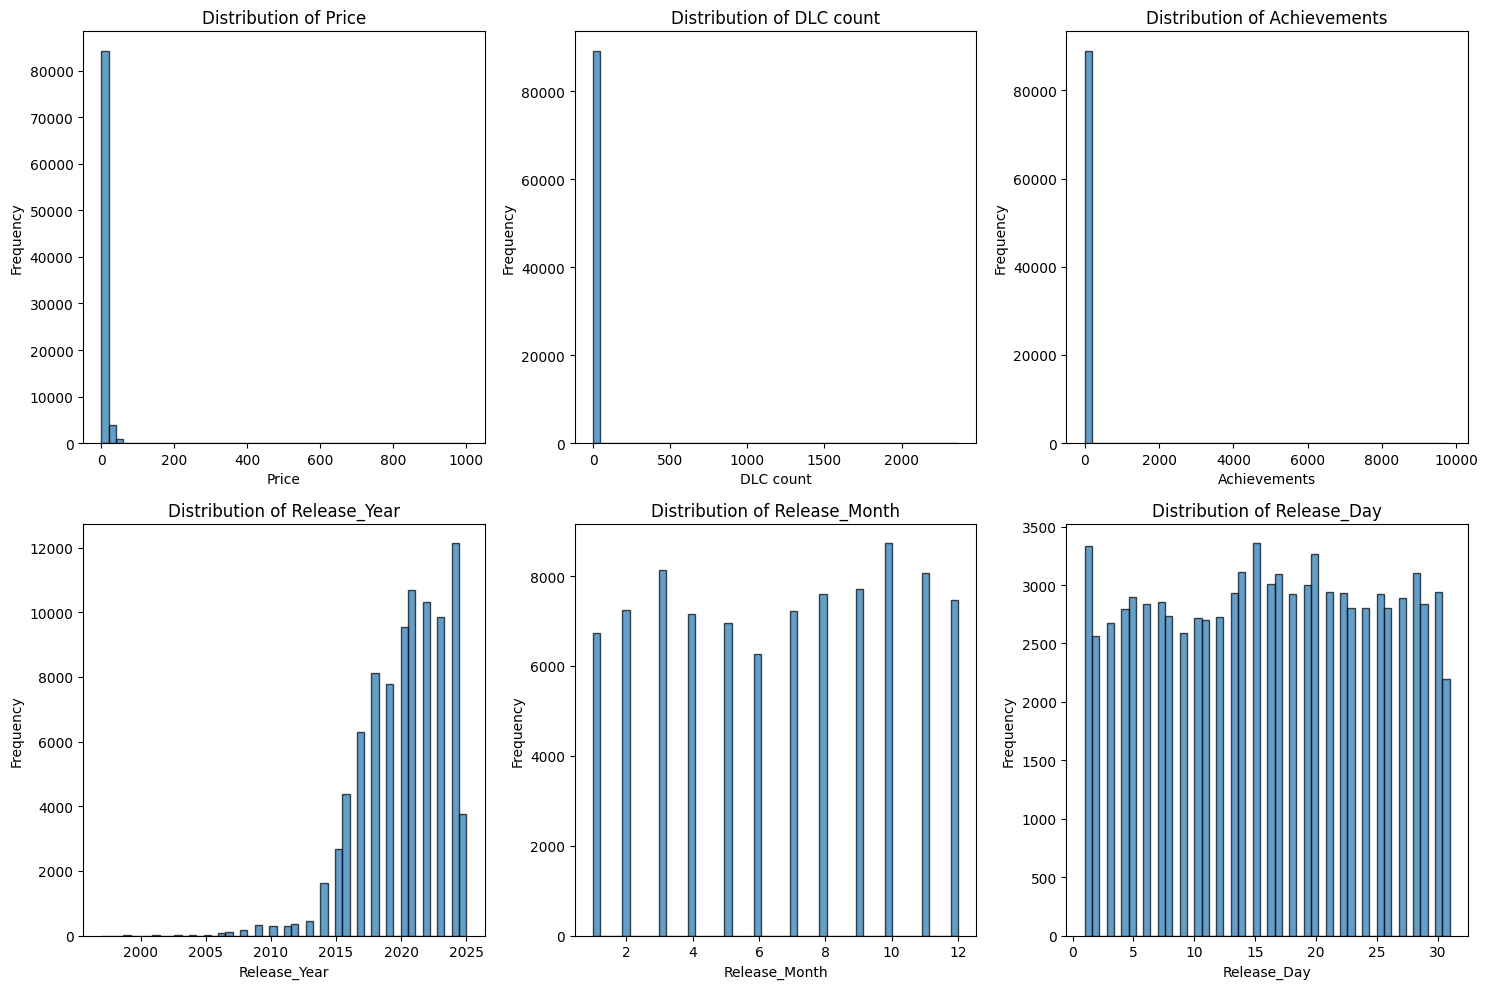

In [14]:
# Visualize distributions of key numerical features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Select key numerical features to visualize
key_numeric_features = numeric_cols[:6] if len(numeric_cols) >= 6 else numeric_cols

for idx, col in enumerate(key_numeric_features):
    if idx < len(axes):
        axes[idx].hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Distribution of {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')

# Hide extra subplots if we have fewer than 6 features
for idx in range(len(key_numeric_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Handling Outliers
Detect and handle outliers using the IQR (Interquartile Range) method.

In [15]:
def detect_outliers_iqr(data, column):
    """
    Detect outliers using IQR method.
    Returns indices of outliers.
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers.index, lower_bound, upper_bound

# Analyze outliers for each numeric column
outlier_summary = []

for col in numeric_cols:
    outlier_indices, lower, upper = detect_outliers_iqr(df, col)
    outlier_count = len(outlier_indices)
    outlier_pct = (outlier_count / len(df)) * 100
    
    outlier_summary.append({
        'Feature': col,
        'Outlier_Count': outlier_count,
        'Outlier_Percentage': outlier_pct,
        'Lower_Bound': lower,
        'Upper_Bound': upper
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values('Outlier_Count', ascending=False)
print("Outlier Analysis:")
print(outlier_df)

Outlier Analysis:
         Feature  Outlier_Count  Outlier_Percentage  Lower_Bound  Upper_Bound
1      DLC count          12452           13.943697         0.00         0.00
2   Achievements           5151            5.768068       -30.00        50.00
0          Price           4978            5.574343       -10.01        21.99
3   Release_Year           1009            1.129874      2010.50      2030.50
4  Release_Month              0            0.000000        -5.00        19.00
5    Release_Day              0            0.000000       -16.00        48.00


In [16]:
# Cap outliers using Winsorization to preserve data while reducing extreme values
# This approach is preferred over removal to maintain sufficient training data
print(f"Dataset size before outlier handling: {len(df)}")

# Get updated list of numeric columns (now includes date features)
current_numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Exclude date features and count variables from outlier handling
date_features = ['Release_Year', 'Release_Month', 'Release_Day']
count_features = ['DLC count', 'Achievements']  # Count variables with natural zero-inflation
cols_to_cap = [col for col in current_numeric_cols if col not in date_features and col not in count_features]

print(f"Columns to cap for outliers: {len(cols_to_cap)}")
print(f"Date features excluded from capping: {[col for col in date_features if col in df.columns]}")
print(f"Count features excluded from capping: {[col for col in count_features if col in df.columns]}")

for col in cols_to_cap:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap outliers
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

# Ensure date features are integers (not floats)
for col in date_features:
    if col in df.columns:
        df[col] = df[col].astype('Int64')  # Int64 handles NaN properly

print(f"\nDataset size after outlier handling: {len(df)}")
print("Outliers have been capped to IQR bounds (excluding date and count features)")
print("Date features converted to integers")

Dataset size before outlier handling: 89302
Columns to cap for outliers: 1
Date features excluded from capping: ['Release_Year', 'Release_Month', 'Release_Day']
Count features excluded from capping: ['DLC count', 'Achievements']

Dataset size after outlier handling: 89302
Outliers have been capped to IQR bounds (excluding date and count features)
Date features converted to integers


# Feature Engineering - Categorical Features
Analyze and encode categorical features. Check for high cardinality features that may need special handling.

In [17]:
# Analyze categorical features
categorical_info = []

for col in categorical_cols:
    unique_count = df[col].nunique()
    top_value = df[col].mode()[0] if len(df[col].mode()) > 0 else None
    top_value_count = (df[col] == top_value).sum() if top_value else 0
    top_value_pct = (top_value_count / len(df)) * 100
    
    categorical_info.append({
        'Feature': col,
        'Unique_Values': unique_count,
        'Top_Value': top_value,
        'Top_Value_Percentage': top_value_pct
    })

categorical_info_df = pd.DataFrame(categorical_info).sort_values('Unique_Values', ascending=False)
print("Categorical Features Analysis:")
print(categorical_info_df)

Categorical Features Analysis:
                Feature  Unique_Values  \
0        About the game          88843   
7                  Tags          67070   
3            Developers          55136   
4            Publishers          48282   
1   Supported languages          13343   
5            Categories           6464   
2  Full audio languages           2557   
6                Genres           2325   

                                           Top_Value  Top_Value_Percentage  
0  Help the beautiful girls to immerse themselves...              0.178048  
7                                       Indie,Casual             17.475532  
3                                    EroticGamesClub              0.217240  
4                                     Big Fish Games              0.951826  
1                                        ['English']             51.655058  
5                                      Single-player             25.371212  
2                                                 [

In [18]:
# For high cardinality features (like Categories, Genres, Tags), 
# we'll use one-hot encoding or handle them separately
# For now, let's check which features have manageable cardinality

print("\nFeatures by cardinality:")
print("Low cardinality (<10):", [col for col in categorical_cols if df[col].nunique() < 10])
print("Medium cardinality (10-50):", [col for col in categorical_cols if 10 <= df[col].nunique() < 50])
print("High cardinality (>=50):", [col for col in categorical_cols if df[col].nunique() >= 50])


Features by cardinality:
Low cardinality (<10): []
Medium cardinality (10-50): []
High cardinality (>=50): ['About the game', 'Supported languages', 'Full audio languages', 'Developers', 'Publishers', 'Categories', 'Genres', 'Tags']


# Encoding Categorical Features
For categorical features:
- **Multi-value features** (Genres, Tags, Categories, Languages): Contain comma-separated values. Convert to binary features for the top 15 most common values.
- **Single-value categorical features**: Remain as text for potential future use.

In [19]:
# Identify multi-value features (Genres, Tags, Categories, Languages)
# These features contain comma-separated values that need to be converted to binary features
multi_value_feature_candidates = ['Genres', 'Tags', 'Categories', 'Supported languages', 'Full audio languages']
multi_value_features = [col for col in multi_value_feature_candidates if col in df.columns]

if multi_value_features:
    print("Multi-value features found:")
    for col in multi_value_features:
        print(f"\n{col}:")
        print(df[col].dropna().head(3))
else:
    print("No multi-value features found")

print(f"\nMulti-value features to process: {multi_value_features}")

# Separate single-value and multi-value categorical features
single_value_categorical = [col for col in categorical_cols if col not in multi_value_features]
print(f"\nSingle-value categorical features: {single_value_categorical}")

Multi-value features found:

Genres:
0                Casual,Indie,Sports
1                       Action,Indie
2    Action,Adventure,Indie,Strategy
Name: Genres, dtype: object

Tags:
0                          Indie,Casual,Sports,Bowling
1    Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...
2                                         Indie,Casual
Name: Tags, dtype: object

Categories:
0    Single-player,Multi-player,Steam Achievements,...
1    Single-player,Steam Achievements,Full controll...
2                                        Single-player
Name: Categories, dtype: object

Supported languages:
0                                          ['English']
1    ['English', 'French', 'Italian', 'German', 'Sp...
2                   ['English', 'Portuguese - Brazil']
Name: Supported languages, dtype: object

Full audio languages:
0    []
1    []
2    []
Name: Full audio languages, dtype: object

Multi-value features to process: ['Genres', 'Tags', 'Categories', 'Supported languages', 'Full aud

In [20]:
# For multi-value features (Categories, Genres, Tags), create binary features for top N values
# This approach is commonly used for multi-label features

import re

def create_top_n_binary_features(df, column, top_n=20):
    """
    Create binary features for the top N most common values in a multi-value column.
    Uses exact matching to avoid substring false positives.
    """
    # Get all values across all rows
    all_values = []
    for val in df[column].dropna():
        if isinstance(val, str):
            all_values.extend([v.strip() for v in val.split(',')])
    
    # Count occurrences
    from collections import Counter
    value_counts = Counter(all_values)
    top_values = [val for val, count in value_counts.most_common(top_n)]
    
    print(f"\nTop {len(top_values)} values in {column}:")
    for val, count in value_counts.most_common(top_n):
        print(f"  {val}: {count}")
    
    # Create binary features
    for value in top_values:
        # skip empty values
        if not value or not value.strip():
            continue
        # make a safe feature name by replacing non-alphanumeric chars with underscores
        safe_value = re.sub(r'[^0-9A-Za-z_]+', '_', value).strip('_')
        # Skip if the safe_value is empty after cleaning
        if not safe_value:
            continue
        feature_name = f"{column}_{safe_value}"
        
        # Use exact matching: check if value is in the comma-separated list
        # This avoids substring matching issues (e.g., "player" matching "Multiplayer")
        def check_exact_match(cell_value):
            if pd.isna(cell_value) or not isinstance(cell_value, str):
                return 0
            # Split by comma and check if our value is in the list
            values_list = [v.strip() for v in cell_value.split(',')]
            return 1 if value in values_list else 0
        
        df[feature_name] = df[column].apply(check_exact_match)
    
    return df, top_values

# Apply to multi-value features
for col in multi_value_features:
    print(f"\n{'='*60}")
    print(f"Processing multi-value feature: {col}")
    df, top_values = create_top_n_binary_features(df, col, top_n=15)
    print(f"Created {len(top_values)} binary features for {col}")


Processing multi-value feature: Genres

Top 15 values in Genres:
  Indie: 62947
  Casual: 37744
  Action: 36566
  Adventure: 34865
  Simulation: 18116
  Strategy: 17062
  RPG: 15991
  Early Access: 11619
  Sports: 4053
  Free to Play: 3630
  Racing: 3321
  Massively Multiplayer: 1869
  Utilities: 868
  Violent: 523
  Design & Illustration: 518
Created 15 binary features for Genres

Processing multi-value feature: Tags

Top 15 values in Tags:
  Indie: 60193
  Casual: 47038
  Singleplayer: 40899
  Action: 32840
  Adventure: 31064
  2D: 21472
  Simulation: 15817
  Strategy: 15772
  RPG: 13960
  Atmospheric: 13662
  3D: 13604
  Puzzle: 13447
  Pixel Graphics: 11276
  Early Access: 11137
  Colorful: 11106
Created 15 binary features for Tags

Processing multi-value feature: Categories

Top 15 values in Categories:
  Single-player: 85694
  Steam Achievements: 41926
  Steam Cloud: 22071
  Full controller support: 18546
  Multi-player: 15880
  Family Sharing: 14321
  Partial Controller Support

In [21]:
# Drop the original multi-value categorical columns
df = df.drop(columns=multi_value_features)
print(f"\nDropped original multi-value columns: {multi_value_features}")
print(f"Current dataset shape: {df.shape}")


Dropped original multi-value columns: ['Genres', 'Tags', 'Categories', 'Supported languages', 'Full audio languages']
Current dataset shape: (89302, 81)


# Feature Scaling
Normalize numerical features using StandardScaler to ensure all features are on the same scale.

**Features excluded from scaling:**
- **Date features** (Release_Year, Release_Month, Release_Day): Have meaningful absolute values
- **Binary features** (Genres, Tags, Categories, Supported languages, Full audio languages): Already 0/1, scaling would destroy interpretability

In [22]:
# Get all numeric columns
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Identify binary features (genres, tags, categories, languages) - these should NOT be scaled
binary_features = [col for col in numeric_features if col.startswith(('Genres_', 'Tags_', 'Categories_', 'Supported languages_', 'Full audio languages_'))]

# Exclude date features and binary features from scaling
date_features = ['Release_Year', 'Release_Month', 'Release_Day']
features_to_scale = [col for col in numeric_features 
                     if col not in date_features 
                     and col not in binary_features]

print(f"Total numeric features: {len(numeric_features)}")
print(f"Date features (not scaled): {len([col for col in date_features if col in numeric_features])}")
print(f"Binary features (not scaled): {len(binary_features)}")
print(f"Features to scale: {len(features_to_scale)}")
print(f"\nContinuous features being scaled: {features_to_scale}")

# Apply StandardScaler only to continuous numeric features
scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

print("\n" + "="*60)
print("Scaling Complete")
print("="*60)
print("\nSample of scaled continuous features:")
if len(features_to_scale) >= 3:
    print(df[features_to_scale[:3]].head())
else:
    print(df[features_to_scale].head())
    
print("\nSample of unscaled binary features (should be 0 or 1):")
if len(binary_features) >= 3:
    print(df[binary_features[:3]].head())
else:
    print(df[binary_features].head())
    
print("\nSample of unscaled date features:")
print(df[[col for col in date_features if col in df.columns]].head())

Total numeric features: 74
Date features (not scaled): 3
Binary features (not scaled): 68
Features to scale: 3

Continuous features being scaled: ['Price', 'DLC count', 'Achievements']

Scaling Complete

Sample of scaled continuous features:
      Price  DLC count  Achievements
0  2.007898  -0.039159      0.057969
1 -0.963858  -0.039159     -0.049630
2 -0.338225  -0.039159     -0.121362
3 -0.181817  -0.039159     -0.121362
4 -1.118702  -0.039159     -0.019741

Sample of unscaled binary features (should be 0 or 1):
   Genres_Indie  Genres_Casual  Genres_Action
0             1              1              0
1             1              0              1
2             1              0              1
3             1              1              0
4             1              0              0

Sample of unscaled date features:
   Release_Year  Release_Month  Release_Day
0          2008             10           21
1          2017             10           12
2          2021             11       

# Final Dataset Overview
Review the preprocessed dataset before saving.

In [23]:
print("="*60)
print("FINAL PREPROCESSED DATASET SUMMARY")
print("="*60)
print(f"\nDataset shape: {df.shape}")
print(f"Total samples: {df.shape[0]}")
print(f"Total features: {df.shape[1]}")

print("\n" + "-"*60)
print("Feature Types:")
print("-"*60)
print(f"Numeric features: {len(df.select_dtypes(include=['int64', 'float64']).columns)}")
print(f"Categorical features: {len(df.select_dtypes(include=['object']).columns)}")

print("\n" + "-"*60)
print("Missing Values:")
print("-"*60)
print(f"Total missing values: {df.isnull().sum().sum()}")

print("\n" + "-"*60)
print("Target Variable Distribution:")
print("-"*60)
print(df['popularity_class'].value_counts())
print("\nPercentage distribution:")
print(df['popularity_class'].value_counts(normalize=True) * 100)

print("\n" + "-"*60)
print("Sample of preprocessed data:")
print("-"*60)
print(df.head(10))

FINAL PREPROCESSED DATASET SUMMARY

Dataset shape: (89302, 81)
Total samples: 89302
Total features: 81

------------------------------------------------------------
Feature Types:
------------------------------------------------------------
Numeric features: 74
Categorical features: 4

------------------------------------------------------------
Missing Values:
------------------------------------------------------------
Total missing values: 0

------------------------------------------------------------
Target Variable Distribution:
------------------------------------------------------------
popularity_class
Low       78429
Medium     8934
High       1939
Name: count, dtype: int64

Percentage distribution:
popularity_class
Low       87.824461
Medium    10.004255
High       2.171284
Name: proportion, dtype: float64

------------------------------------------------------------
Sample of preprocessed data:
------------------------------------------------------------
      Price  DLC co

# Reorder Columns
Move the target variable to the end of the dataset

In [24]:
# Move target variable to the last column
if 'popularity_class' in df.columns:
    cols = [col for col in df.columns if col != 'popularity_class']
    cols.append('popularity_class')
    df = df[cols]
    print("Target variable 'popularity_class' moved to the last column")
    print(f"\nColumn order (last 5 columns): {df.columns[-5:].tolist()}")

Target variable 'popularity_class' moved to the last column

Column order (last 5 columns): ['Full audio languages_Japanese', 'Full audio languages_Traditional_Chinese', 'Full audio languages_Portuguese_Brazil', 'Full audio languages_Polish', 'popularity_class']


In [25]:
df.head()

,Price,DLC count,About the game,Windows,Mac,Linux,Achievements,Developers,Publishers,Release_Year,Release_Month,Release_Day,Genres_Indie,Genres_Casual,Genres_Action,Genres_Adventure,Genres_Simulation,Genres_Strategy,Genres_RPG,Genres_Early_Access,Genres_Sports,Genres_Free_to_Play,Genres_Racing,Genres_Massively_Multiplayer,Genres_Utilities,Genres_Violent,Genres_Design_Illustration,Tags_Indie,Tags_Casual,Tags_Singleplayer,Tags_Action,Tags_Adventure,Tags_2D,Tags_Simulation,Tags_Strategy,Tags_RPG,Tags_Atmospheric,Tags_3D,Tags_Puzzle,Tags_Pixel_Graphics,Tags_Early_Access,Tags_Colorful,Categories_Single_player,Categories_Steam_Achievements,Categories_Steam_Cloud,Categories_Full_controller_support,Categories_Multi_player,Categories_Family_Sharing,Categories_Partial_Controller_Support,Categories_Steam_Trading_Cards,Categories_PvP,Categories_Co_op,Categories_Steam_Leaderboards,Categories_Online_PvP,Categories_Remote_Play_Together,Categories_Shared_Split_Screen,Categories_Online_Co_op,Supported languages_English,Supported languages_German,Supported languages_French,Supported languages_Spanish_Spain,Supported languages_Simplified_Chinese,Supported languages_Italian,Supported languages_Russian,Supported languages_Japanese,Supported languages_Portuguese_Brazil,Supported languages_Korean,Supported languages_Polish,Supported languages_Traditional_Chinese,Full audio languages_English,Full audio languages_German,Full audio languages_French,Full audio languages_Spanish_Spain,Full audio languages_Italian,Full audio languages_Russian,Full audio languages_Simplified_Chinese,Full audio languages_Japanese,Full audio languages_Traditional_Chinese,Full audio languages_Portuguese_Brazil,Full audio languages_Polish,popularity_class
0,2.007898,-0.039159,Galactic Bowling is an exaggerated and stylize...,True,False,False,0.057969,Perpetual FX Creative,Perpetual FX Creative,2008,10,21,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Low
1,-0.963858,-0.039159,THE LAW!! Looks to be a showdown atop a train....,True,True,False,-0.049630,Rusty Moyher,Wild Rooster,2017,10,12,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Low
2,-0.338225,-0.039159,Jolt Project: The army now has a new robotics ...,True,False,False,-0.121362,Campião Games,Campião Games,2021,11,17,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Low
3,-0.181817,-0.039159,HENOSIS™ is a mysterious 2D Platform Puzzler w...,True,True,True,-0.121362,Odd Critter Games,Odd Critter Games,2020,7,23,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Low
4,-1.118702,-0.039159,ABOUT THE GAME Play as a hacker who has arrang...,True,True,False,-0.019741,Unusual Games,Unusual Games,2020,2,3,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Low


In [26]:
df.shape

(89302, 81)

# Saving Preprocessed Dataset
Save the preprocessed dataset to CSV for use in machine learning models.

In [27]:
output_path = 'data/processed/games_preprocessed.csv'

df.to_csv(output_path, index=False)

print(f"Preprocessed dataset saved to: {output_path}")
print(f"File size: {df.shape[0]} rows × {df.shape[1]} columns")

Preprocessed dataset saved to: data/processed/games_preprocessed.csv
File size: 89302 rows × 81 columns


# Summary of Preprocessing Steps

This notebook completed the following preprocessing steps:

1. **Data Loading**: Loaded the fixed games dataset (games_fixed.csv)

2. **Feature Selection**: 
   - Removed irrelevant features (URLs, images, identifiers)
   - Removed "cheat" features (post-launch metrics like Peak CCU, reviews, playtime)
   - Kept "About the game" text field untouched for future NLP processing
   - Parsed "Release date" into numeric features: Release_Year, Release_Month, Release_Day

3. **Target Variable Transformation**:
   - Removed rows with "0 - 0" estimated owners (noisy data)
   - Created categorical target variable `popularity_class` with 3 levels: Low, Medium, High
   - Removed original `Estimated owners` column

4. **Data Cleaning**:
   - Handled missing values using median imputation for numeric features
   - Handled missing values using mode imputation for categorical features
   - Dropped rows with remaining missing values (e.g., missing target)
   - Removed duplicate records

5. **Outlier Detection and Handling**:
   - Detected outliers using IQR method
   - Capped outliers to preserve data (Winsorization)

6. **Feature Engineering**:
   - Explicitly identified multi-value categorical features (Genres, Tags, Categories, Supported languages, Full audio languages)
   - Created binary features for top 15 values in each multi-value feature
   - Dropped original multi-value columns after encoding

7. **Feature Scaling**:
   - Applied StandardScaler only to continuous numeric features (price, DLC count, etc.)
   - **Excluded from scaling:**
     - Date features (Release_Year, Release_Month, Release_Day) - preserve temporal meaning
     - Binary features (Genres_*, Tags_*, Categories_*, Supported languages_*, Full audio languages_*) - keep as 0/1 for interpretability

8. **Output**:
   - Saved preprocessed dataset to `data/processed/games_preprocessed.csv`
   - "About the game" text field remains untouched and ready for NLP analysis

<h3>NLP for Descriptions (SBERT Embedded Vectors)</h3>

<b>This cell will install the appropriately needed items for the actual NLP in the coming cell</b>  
Note: You may need to run the three commands commented out at the top of this cell to flush your  
 installs of transformers and sentence-transformers as newer versions than 4.46.3 and 3.2.0 respectively  
 have moved the SentenceTransformer outside of sentence_transformers, leading to a broken import path

In [ ]:
# %pip uninstall -y transformers
# %pip uninstall -y sentence-transformers
# %pip cache purge
# %pip install nltk # not required
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu126
# FOR INTEL GPUs (maybe, unverified), uncomment below and comment out above for intel gpu install
# %pip install torch torchvision --index-url https://download.pytorch.org/whl/xpu

%pip install tf-keras # Added Keras installation since it was needed for one of the other libraries
%pip install transformers==4.46.3
%pip install sentence-transformers==3.2.0

from colorama import Fore, Style # colored output
import transformers
import sentence_transformers
import torch

# none of this is required but I figured I'd leave it in here to show I tried it
# for multi hot encoding, but SBERT is much more accurate
# import nltk
# nltk.download('punkt_tab')
# nltk.download('wordnet')
# nltk.download('stopwords')
# from nltk.tokenize import sent_tokenize as tokenize # tokenizing has never been easier

from sentence_transformers import SentenceTransformer

# versions of libraries in pretty bright green text
print(Style.BRIGHT + Fore.GREEN + "TRANSFORMERS VERSION: ", transformers.__version__)
print(Fore.GREEN +"SENTENCE_TRANSFORMERS VERSION: ", sentence_transformers.__version__)
print(Fore.GREEN + "TORCH VERSION: ", torch.__version__)

Looking in indexes: https://download.pytorch.org/whl/cu126
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

TRANSFORMERS VERSION:  4.46.3
SENTENCE_TRANSFORMERS VERSION:  3.2.0
TORCH VERSION:  2.9.0+cu126


<b>This is the actual NLP for each game's 'About the game' section</b>  
  
<b>Main Idea:</b>
1. import a model that is trained in human language (All-MiniLM-L6-v2 in our case)
2. pass that model and our dataframe to preprocessDescs  
3. The function will grab all the descriptions and return a list of embedded vectors each size 384 (how the machine 'understands' language, not really for our understanding)
4. assign these vectors to our dataframe in place of the textual descriptions in 'About the game'  
  
Granted we could train our own model, but it is extremely time consuming and I believed to be outside the scope of the class,  
(although it could have been our project instead) therefore I chose to import one from a popular machine learning platform.  
  
I originally attempted to execute the embedding with my Samsung laptop, using the CPU only. However, if you attempt to run it this way,  
you may run into the issue of extremely slow processing due to CPUs apparently not being optimized for massive tensor ops like GPUs are.  
After ~10 minutes of runtime on my intel CPU, I had about 300 out of 80000+ descriptions done.  
After ~1-2 minutes of runtime on my Nvidia 3090 GPU, I had all descriptions finished.

<b>Note: You should only run this if you have a <i>GOOD Nvidia GPU</i>, as the version of torch torchvision with 'cu126' is for Nvidia GPUs only.     
I also did some research into other implementations and saw that this can work with 'xpu' instead of 'cu126' for select intel GPUs, however I was unable to verify this as I do not have a valid intel GPU on hand.</b>  
  


In [ ]:
def preprocessDescs(df, model):
    # assign each description to an index in a list so we can keep each description separate from one another
    # this may be redundant but I haven't tested it
    temp = []
    for i in df['About the game'].index:
        temp.append(df['About the game'][i])

    
    embeddings = [] # stores embedded vector for each description (each size 384)

    # this for loop takes descriptions in batches of 64 to accelerate the embedding process
    # uses your Nvidia GPU to speed up embedding by 100 or more times
    for i in range(0, len(temp), 64):
        batch = temp[i:i+64]
        batchedEmbed = model.encode(batch, ProgressBar=True, convert_to_numpy=True)
        embeddings.extend(batchedEmbed)

    embeddings = np.array(embeddings)
    return embeddings


# machine model from SBERT
model = SentenceTransformer("All-MiniLM-L6-v2", device = "cuda")

# call to function
embeddedDescs = []
embeddedDescs = preprocessDescs(df, model)

# lengths should be equal (they will be unless you mess with the above code)
print(Fore.GREEN + "TOTAL EMBEDDED DESCRIPTIONS (expected == to dataframe total rows): ", len(embeddedDescs))
print(Fore.GREEN + "TOTAL DATA POINTS IN DATAFRAME (expected == total embedded vectors): ",  len(df))

# convert to list so entire element in each index (not just first index [i][0]) is stored in each cell
df['About the game'] = list(embeddedDescs)


<b>This is just the output portion for the above code so you dont have to rerun it over and over since it may take a while</b>

In [ ]:
# You can swap this number with 0, 1, 2, etc to see other embeddings 
# and change the df.head() to a specific index to see that embedding
print(embeddedDescs[0])
# pd.set_option('display.max_colwidth', None) # allows more data to display in 'About the game' column (still not all of it though)
# pd.reset_option('display.max_colwidth') # resets to default after about code
display(df.head())
print(Fore.GREEN + "SIZE OF EACH EMBEDDED VECTOR (expected 384): ", len(df['About the game'][0]))

<b>In the table above, you can see that "About the game" appears to have only taken on the first few values in each embedded vector (translated from scientific notation automatically)</b>
<b>This is not the case however, and the entire vector actually appears in each slot, as seen by the size output in green.

## Save Dataset with NLP Embeddings

Now that the 'About the game' column has been replaced with NLP embeddings (384-dimensional vectors), save the preprocessed dataset to CSV.

In [ ]:
# Save the dataset with NLP embeddings to CSV
# This replaces the previous games_preprocessed.csv file
output_path_with_nlp = 'data/processed/games_preprocessed.csv'

df.to_csv(output_path_with_nlp, index=False)

print(Style.BRIGHT + Fore.GREEN + f"✓ Preprocessed dataset with NLP embeddings saved to: {output_path_with_nlp}")
print(Fore.GREEN + f"✓ File size: {df.shape[0]} rows × {df.shape[1]} columns")
print(Fore.GREEN + f"✓ 'About the game' column now contains 384-dimensional NLP embeddings")